In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from scipy.stats import uniform, randint, hmean

In [2]:
SEED = 42
PATH = '../dataset/csv/healthcare-dataset-stroke-data.csv'

## 各カラムの意味確認

- id: 患者id => 不要

- gender: 性別(Male or Female　or other) => カテゴリ変数

- age: 年齢 => 量的変数

- hypertension: 高血圧 => カテゴリ変数

- heart_disease: 心臓病有無 => カテゴリ変数

- ever_married: 結婚歴(Yes or No) => カテゴリ変数

- work_type: 仕事の種類 => カテゴリ変数

    - private: 民間企業

    - self employed: 個人事業主
    
    - govt_jobs: government jobs(公務員のイメージ)
    
    - children: 子ども?
    
    - Never_worked: 就業経験なし

- Residence_type: 居住タイプ => カテゴリ変数

    - Urban: 都市部
    
    - Rural: 田舎

- avg_glucose_level: グルコース平均 => 量的変数

- bmi: bmi => 量的変数

- smoking_status: 喫煙ステータス => カテゴリ変数

- stroke: 脳卒中有無(目的変数) => カテゴリ変数

In [3]:
df = pd.read_csv(PATH)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# bmiに201個のnullがある
display(df.info())
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


None

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

## カテゴリ変数可視化

- stroke(目的変数)

- gender

- hypertension

- heart_disease

- ever_married

- work_type

- Residence_type(不要? => 分布にほとんど差がないので)

- smoking_status

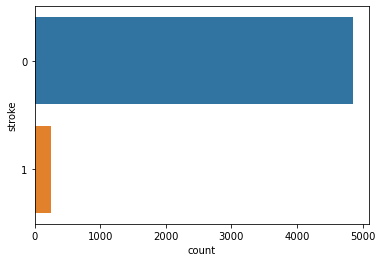

In [4]:
# 目的変数のプロット => データ不均衡が大きい(一旦そのまま学習してみる)
sns.countplot(data=df, y='stroke')
plt.show()

gender


Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

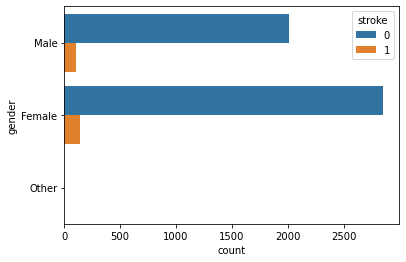

hypertension


0    4612
1     498
Name: hypertension, dtype: int64

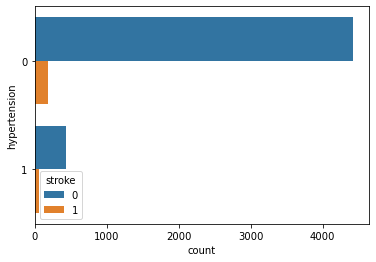

heart_disease


0    4834
1     276
Name: heart_disease, dtype: int64

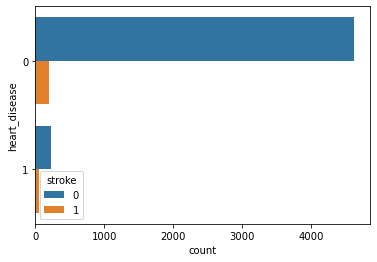

ever_married


Yes    3353
No     1757
Name: ever_married, dtype: int64

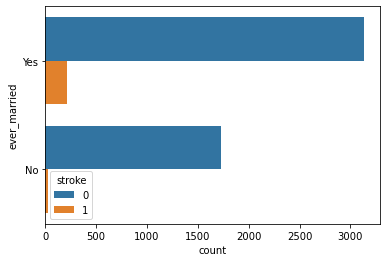

work_type


Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

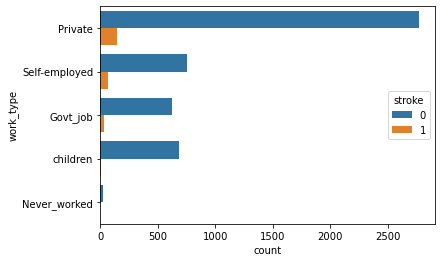

Residence_type


Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

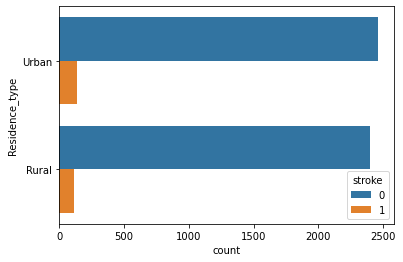

smoking_status


never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

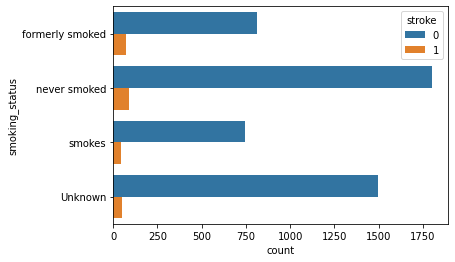

In [6]:
target_colmuns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in target_colmuns:
    print(col)
    display(df[col].value_counts())
    sns.countplot(data=df, y=col, hue='stroke')
    plt.show()

## 量的変数の可視化

- age

- bmi

- avg_glucose_level

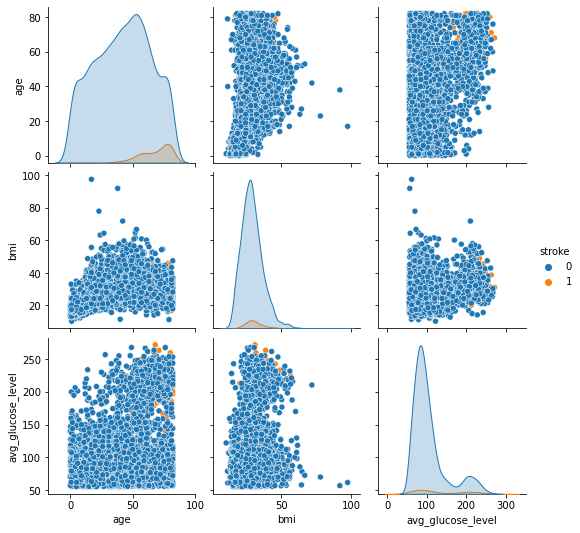

In [5]:
target_cols = ['age', 'bmi', 'avg_glucose_level', 'stroke']
sns.pairplot(data=df[target_cols], hue='stroke')
plt.show()

## カテゴリ変数の処理

- stroke(目的変数)

- gender: pd.get_dummy

- hypertension: そのまま

- heart_disease: そのまま

- ever_married: pd.get_dummy

- work_type: pd.get_dummy

- Residence_type: pd.get_dummy

- smoking_status: pd.get_dummy

In [6]:
ENCODED_DST = Path('../dataset/processed/category_encoded.csv')
ENCODED_DST.parent.mkdir(parents=True, exist_ok=True)
df = pd.read_csv(PATH)
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)
df.info()
df.to_csv(ENCODED_DST, index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              5110 non-null   int64  
 1   age                             5110 non-null   float64
 2   hypertension                    5110 non-null   int64  
 3   heart_disease                   5110 non-null   int64  
 4   avg_glucose_level               5110 non-null   float64
 5   bmi                             4909 non-null   float64
 6   stroke                          5110 non-null   int64  
 7   gender_Male                     5110 non-null   uint8  
 8   gender_Other                    5110 non-null   uint8  
 9   ever_married_Yes                5110 non-null   uint8  
 10  work_type_Never_worked          5110 non-null   uint8  
 11  work_type_Private               5110 non-null   uint8  
 12  work_type_Self-employed         51

## 欠損値処理 + 不要値の削除
- bmiの欠損値を中央値で埋める

- idはいらないので削除

In [9]:
TRAINABLE_CSV = Path('../dataset/processed/trainable.csv')
TRAINABLE_CSV.parent.mkdir(parents=True, exist_ok=True)
# bmiの中央値埋め
df = pd.read_csv(ENCODED_DST)
df['bmi'] = df['bmi'].fillna(value=df['bmi'].median())
# idカラムの削除
df.drop('id', axis=1, inplace=True)
df.info()
df.to_csv(TRAINABLE_CSV, index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   avg_glucose_level               5110 non-null   float64
 4   bmi                             5110 non-null   float64
 5   stroke                          5110 non-null   int64  
 6   gender_Male                     5110 non-null   int64  
 7   gender_Other                    5110 non-null   int64  
 8   ever_married_Yes                5110 non-null   int64  
 9   work_type_Never_worked          5110 non-null   int64  
 10  work_type_Private               5110 non-null   int64  
 11  work_type_Self-employed         5110 non-null   int64  
 12  work_type_children              51

## 学習実施

以下の観点からRandomForestを使用

- 標準化などの前処理が不要

- そこそこ高性能(lightGBMなどのほうがよいが、趣向を変えて)

In [3]:
TRAINABLE_CSV = Path('../dataset/processed/trainable.csv')
df = pd.read_csv(TRAINABLE_CSV)
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,1,0,1,0,1,0,0,1,1,0,0
1,61.0,0,0,202.21,28.1,1,0,0,1,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,1,0,1,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.4,1,0,0,1,0,1,0,0,1,0,0,1
4,79.0,1,0,174.12,24.0,1,0,0,1,0,0,1,0,0,0,1,0


### デフォルト引数で学習

In [4]:
def get_dataset(df):
    X, y = df.drop('stroke', axis=1), df['stroke']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
    return X_train, X_test, y_train, y_test


def plot_pr_curve(precision, recall):
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show()
    
    
def plot_f1_recall_and_precision_changing_th(precision, recall, thresholds):
    f1_scores = []
    for p, r in zip(precision, recall):
        f1 = hmean([p, r])
        f1_scores.append(f1)
    plt.plot(thresholds, f1_scores[:-1], label='f1 score')
    plt.plot(thresholds, recall[:-1], label='recall')
    plt.plot(thresholds, precision[:-1], label='precision')
    plt.xlabel('threshold')
    plt.legend()
    print(f'{np.argmax(f1_scores)}th threshold(={thresholds[np.argmax(f1_scores)]:.2f}) is highest f1 score ={np.max(f1_scores):.2f}')
    return thresholds[np.argmax(f1_scores)]


def eval_model(y_true, y_pred):
    # PR曲線描画
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred[:, 1])
    plot_pr_curve(precision, recall)
    best_f1_score = plot_f1_recall_and_precision_changing_th(precision, recall, thresholds)
    # 混同行列描画
    y_pred_by_th = np.where(y_pred[:, 1] > best_f1_score, 1, 0)
    cm = confusion_matrix(y_true, y_pred_by_th)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    # レポート作成
    print(classification_report(y_true, y_pred_by_th))

In [6]:
X_train, X_test, y_train, y_test = get_dataset(df)
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([3663,  169])), (array([0, 1]), array([1198,   80])))

In [7]:
rfc = RandomForestClassifier(random_state=SEED, class_weight='balanced')
scores = cross_validate(rfc, X_train, y_train, scoring=['accuracy', 'f1', 'recall', 'precision'])
scores

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([0.19668245, 0.18947172, 0.18945432, 0.18938231, 0.18700266]),
 'score_time': array([0.01634741, 0.01679325, 0.01611972, 0.01518345, 0.01515388]),
 'test_accuracy': array([0.95697523, 0.95567145, 0.95822454, 0.95169713, 0.95561358]),
 'test_f1': array([0.05714286, 0.        , 0.05882353, 0.        , 0.        ]),
 'test_recall': array([0.02941176, 0.        , 0.03030303, 0.        , 0.        ]),
 'test_precision': array([1., 0., 1., 0., 0.])}

In [8]:
rfc = RandomForestClassifier(random_state=SEED, class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred = rfc.predict_proba(X_test)

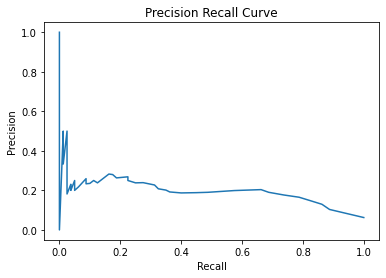

7th threshold(=0.07) is highest f1 score =0.31
              precision    recall  f1-score   support

           0       0.97      0.85      0.90      1198
           1       0.20      0.57      0.30        80

    accuracy                           0.83      1278
   macro avg       0.58      0.71      0.60      1278
weighted avg       0.92      0.83      0.86      1278



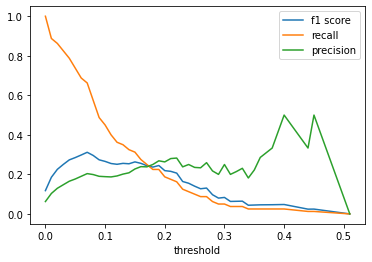

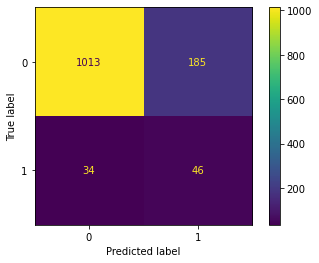

In [9]:
eval_model(y_true=y_test, y_pred=y_pred)

### データのオーバーサンプリング

In [13]:
X_train, X_test, y_train, y_test = get_dataset(df)
ros = SMOTE(random_state=SEED, sampling_strategy='minority')
X_train, y_train = ros.fit_resample(X_train, y_train)
np.unique(y_train, return_counts=True)

(array([0, 1]), array([3663, 3663]))

In [14]:
rfc = RandomForestClassifier(random_state=SEED)
scores = cross_validate(rfc, X_train, y_train, scoring=['accuracy', 'f1', 'recall', 'precision'])
scores

{'fit_time': array([0.38144112, 0.37895608, 0.38050675, 0.38994193, 0.38854861]),
 'score_time': array([0.02224684, 0.02241659, 0.02389956, 0.0222261 , 0.02238512]),
 'test_accuracy': array([0.90859482, 0.95904437, 0.97406143, 0.96860068, 0.97133106]),
 'test_f1': array([0.90359712, 0.95978552, 0.97463284, 0.96933333, 0.97188755]),
 'test_recall': array([0.85675307, 0.97814208, 0.99726776, 0.99181446, 0.9904502 ]),
 'test_precision': array([0.95585997, 0.94210526, 0.95300261, 0.94784876, 0.95400788])}

In [15]:
rfc = RandomForestClassifier(random_state=SEED)
rfc.fit(X_train, y_train)
y_pred = rfc.predict_proba(X_test)

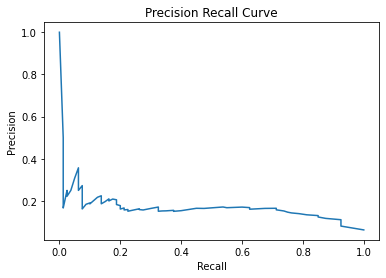

13th threshold(=0.13) is highest f1 score =0.27
              precision    recall  f1-score   support

           0       0.97      0.77      0.86      1198
           1       0.16      0.68      0.26        80

    accuracy                           0.77      1278
   macro avg       0.57      0.72      0.56      1278
weighted avg       0.92      0.77      0.82      1278



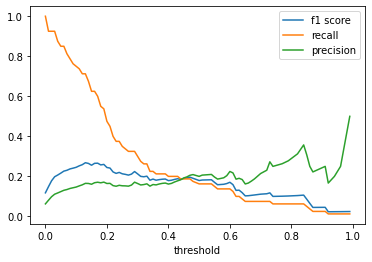

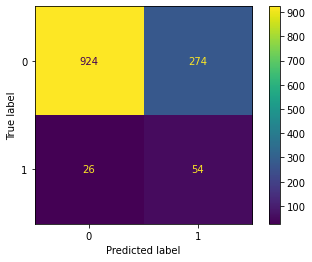

In [16]:
eval_model(y_true=y_test, y_pred=y_pred)